In [1]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter
from scipy import stats 

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

# from statsmodels.formula.api import ols, mixedlm
# import statsmodels.api as sm

## Saving data dictionaries
import pickle

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle, encoding='latin1')

In [31]:
fs = 512.
sfreq = 512.

def get_lfps(sub):
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    lfp_ga = np.mean(lfp,0)
    cc = hpc_electrodes[sub]
    tmp_lfp = lfp[cc] - lfp_ga    
    return tmp_lfp


def get_epochs(tmp_lfp, sub, randomize_events=False):
    canais = []
    for can in range(tmp_lfp.shape[0]):
        trii = []
        for ii in trials_markers[sessions[sub]]:    
            if randomize_events == True: ii += np.random.randint(sfreq*2,sfreq*9)
#             trii.append(  tmp_lfp[can][  ii-int(sfreq*2):ii+int(sfreq*9) ]   )        
            trii.append(  tmp_lfp[can][  ii-int(sfreq*2):ii+int(sfreq*4) ]   )        
        canais.append(trii)
    canais = np.array(canais)
    canais = np.swapaxes(canais,0,1)    
    return canais
    
def get_power(canais, freqs, output='power'):    
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power = tfr_array_multitaper(    canais , sfreq, freqs=freqs, output=output )
    return power
    
    
def plot_spect(spect_data, freqs):
    plt.imshow(  spect_data  , aspect='auto', origin='low', cmap='jet'     )
    plt.yticks(  np.arange(len(freqs))[::2], freqs.round(2)[::2] );
    plt.colorbar()

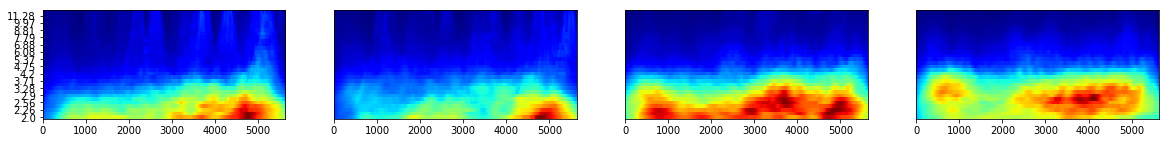

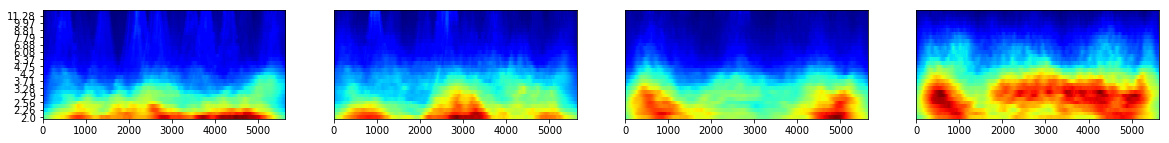

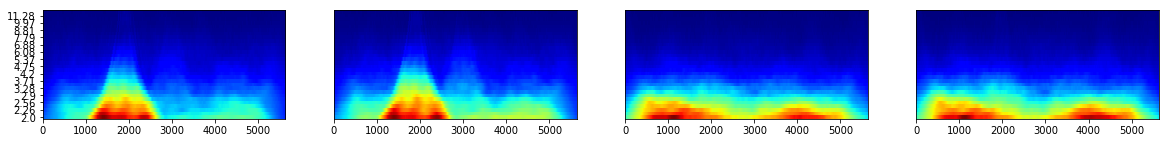

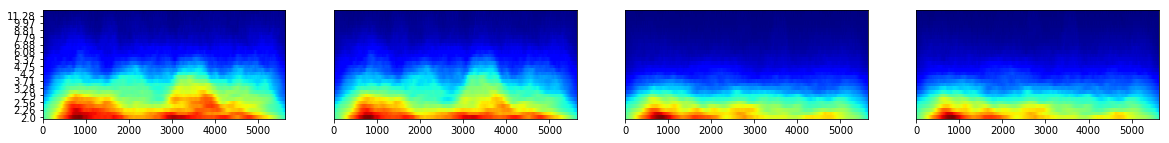

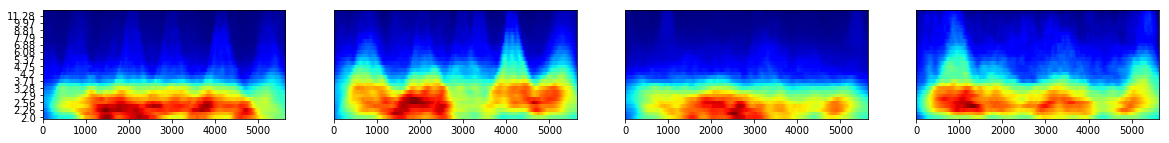

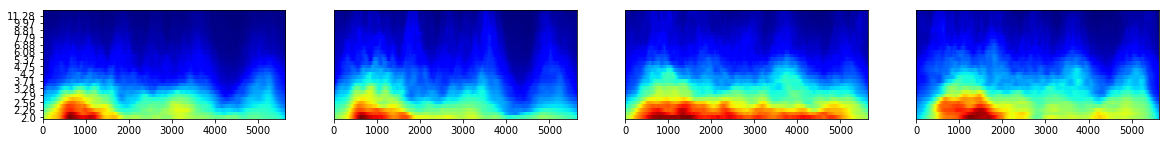

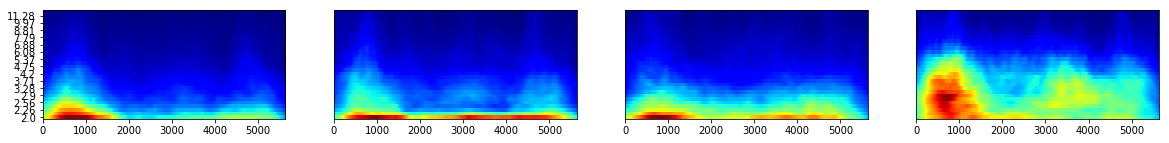

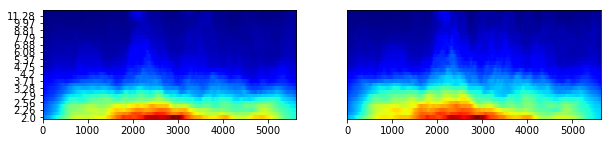

In [11]:
freqs = np.logspace(*np.log10([2, 12]), num=30) # define frequencies of interest (log-spaced)

for sub in range(len(sessions)):

    tmp_lfp = get_lfps(sub)
    tmp_lfp = get_epochs(tmp_lfp, sub)
    power = get_power(tmp_lfp, freqs, output='avg_power')
    
    plt.figure(  figsize=( power.shape[0] * 5 , 2   ) )
    for pp in range(power.shape[0]):
        plt.subplot( 1, power.shape[0], pp+1  )
        
        plt.imshow(  power[pp] , aspect='auto', origin='low', cmap='jet'     )            
        if pp==0: plt.yticks(  np.arange(len(freqs))[::2], freqs.round(2)[::2] );
        else: plt.yticks([]);


In [57]:
freqs = np.logspace(*np.log10([2, 12]), num=30) # define frequencies of interest (log-spaced)

log_itcs = []

output = 'itc'

for sub in range(len(sessions)):
# for sub in range(2,3):

    tmp_lfp = get_lfps(sub)
    tmp_lfp = get_epochs(tmp_lfp, sub, randomize_events=False)
    power = get_power(tmp_lfp, freqs, output=output)
    
    
    if output in ['itc', 'avg_power' ]: ll = power.shape[0]-1
    if output == 'power': ll = power.shape[1]-1
    
    for pp in [ll]:
        if output in ['itc', 'avg_power' ]: log_itcs.append( power[pp] )
        if output == 'power': log_itcs.append( np.mean(power[:,pp,:,:],0) )


In [58]:
ch = 0


duration = power.shape[-1] / sfreq
times = np.linspace(  0, duration, power.shape[-1] )


tmp_power = np.mean(power[:,ch,:,:],axis=0)


plt.figure(facecolor='white')

plt.imshow( tmp_power, cmap='jet',
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower' )

plt.colorbar()



IndexError: too many indices for array

In [59]:
log_itcs = np.array(log_itcs)
log_itcs_m = np.mean( log_itcs, 0 )

stat_fun(H1): min=0.000000 max=31.350274
Running initial clustering
Found 117 clusters
Permuting 99 times...
[........................................] 100.00%  |   
Computing cluster p-values
Done.


Text(0, 0.5, 'Frequency (Hz)')

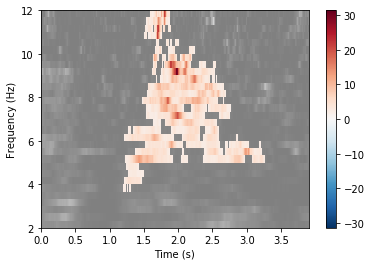

In [65]:
threshold = 2.1
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test( [ log_itcs[:,:,:2000] , log_itcs[:,:,-2000:] ], 
                                         n_permutations=100, threshold=threshold, tail=0)


duration = 2000 / sfreq
times = np.linspace(  0, duration, 2000 )

# Create new stats image with only significant clusters
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

vmax = np.max(np.abs(T_obs))
vmin = -vmax



plt.imshow(T_obs, cmap=plt.cm.gray,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.imshow(T_obs_plot, cmap=plt.cm.RdBu_r,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


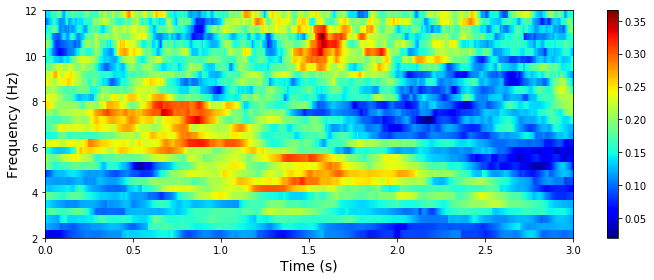

In [84]:
duration = log_itcs[1].shape[1] / sfreq
times_trial = np.linspace(  0, duration, log_itcs[1].shape[1] ) - 3.

plt.figure(figsize=(10,4))

plt.imshow( log_itcs[6], cmap='jet',
           extent=[times_trial[0], times_trial[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower' )

plt.colorbar()

plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Frequency (Hz)',fontsize=14)

plt.xlim(0)

plt.tight_layout()
# plt.savefig('../Figures/power_throughout_navigation.pdf')

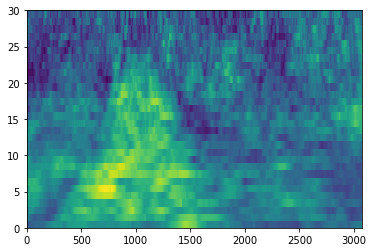

In [73]:
plt.pcolormesh(log_itcs[7])